In [1]:
# import packages
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core import Workspace

# set up AzureML workspace
config_path = '../../utils/config.json'
tenant_id = '72f988bf-86f1-41af-91ab-2d7cd011db47'  # this is outputted post `az login`
interactive_auth = InteractiveLoginAuthentication(tenant_id=tenant_id)  # create log-in object
ws = Workspace.from_config(path=config_path, auth=interactive_auth)  # link workspace


If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


In [2]:
# import packages
import shutil, os
from sklearn.ensemble import IsolationForest

# copy over script for model creation
shutil.copy('../../src/triton/triton_isolation_forest.py', '.')
from triton_isolation_forest import *

# TODO: move this onto azure
# preprocess data
url = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz'  # URL of the public dataset
df = download_data(url)  # read data from the url
df = process_data(df)  # subset the data and select top labels
# split data
train, test_norm, test_anom = split_data(df)
X_train, y_train = train  # unpack training data
# train model
model = IsolationForest(random_state=RAND_STATE)
model.fit(X_train)
# convert into ONNX format
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
initial_types = [('float_input', FloatTensorType([None, X_train.shape[1]]))]
onx = convert_sklearn(model, initial_types=initial_types)
with open('../../src/triton/isolation_forest.onnx', 'wb') as f:
    f.write(onx.SerializeToString())
os.remove('triton_isolation_forest.py')


In [3]:
# define helper functions
def instantiate_models(src_file):
    '''
    creates the expected triton directory system given a source model file
    '''
    # extract model name and source file name
    src_name = os.path.basename(src_file)
    model_name = src_name.split('.')[0]  # assumes a <model>.onnx structure
    # set outputted directory name and model filename
    dir_name = f'models/triton/{model_name}/1/'
    file_name = f'{dir_name}{src_name}'
    # copies the data over
    os.makedirs(dir_name, exist_ok=True)  # instantiate directory
    shutil.copy(src_file, file_name)  # copy model onnx file
    # return the file/directory locations
    return dir_name, file_name

def remove_models():
    '''
    removes the models directory where the triton inputs are stored
    '''
    try:
        shutil.rmtree('models')
    except:
        print('No models have been created')


In [4]:
# import packages
from azureml.core.model import Model

# setup model for registration
dir_name,file_name = instantiate_models('../../src/triton/isolation_forest.onnx')
# register model
model = Model.register(
    model_path='models',
    model_name='IsolationForestTutorial',
    description='Anomaly detection for KDD network intrusion dataset',
    workspace=ws,
    model_framework=Model.Framework.MULTI,
)


Registering model IsolationForestTutorial


In [5]:
# import packages
from azureml.core.webservice import LocalWebservice
from azureml.core.model import InferenceConfig
from azureml.core import Environment

# setup environment (obtain environment.yml from `conda env export > environment.yml`)
env_name,env_path = 'SampleEnv', '../../utils/environment_triton.yml'
env = Environment.from_conda_specification(name=env_name, file_path=env_path)

# setup service for deployment
service_name = 'triton-isolation-forest'
infer_config = InferenceConfig('../../utils/entry_script.py', environment=env)
# TODO: make this an online webservice?
deploy_config = LocalWebservice.deploy_configuration(port=6789)
# deploy service
service = Model.deploy(
    workspace=ws,
    name=service_name,
    models=[model],
    inference_config=infer_config,
    deployment_config=deploy_config,
    overwrite=True,
)
# check deployment status
service.wait_for_deployment(show_output=True)


Generating Docker build context.
Package creation Succeeded
Logging into Docker registry 27ebdbdbb34a4186a9c6cf92029c3be2.azurecr.io
Logging into Docker registry 27ebdbdbb34a4186a9c6cf92029c3be2.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM 27ebdbdbb34a4186a9c6cf92029c3be2.azurecr.io/azureml/azureml_ecf213f7d8b434ab6b63c09a1aa13a32
 ---> ecd57fef7673
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> f16b03e4f278
Step 3/5 : RUN mkdir -p '/var/azureml-app' && echo eyJhY2NvdW50Q29udGV4dCI6eyJzdWJzY3JpcHRpb25JZCI6IjY1NjA1NzVkLWZhMDYtNGU3ZC05NWZiLWY5NjJlNzRlZmQ3YSIsInJlc291cmNlR3JvdXBOYW1lIjoidXdfYW5vbWFseWRldGVjdGlvbiIsImFjY291bnROYW1lIjoiYW5vbWFseWRldGVjdGlvbiIsIndvcmtzcGFjZUlkIjoiMjdlYmRiZGItYjM0YS00MTg2LWE5YzYtY2Y5MjAyOWMzYmUyIn0sIm1vZGVscyI6e30sIm1vZGVsc0luZm8iOnt9fQ== | base64 --decode > /var/azureml-app/model_config_map.json
 ---> Running in 9a1441097743
 ---> cf5fd03885e4
Step 4/5 : RUN mv '/var/azureml-app/tmp_24tw2pi.py' /var/azureml-app/main.py
 ---> Runnin

In [6]:
# print logs
print('Local service port: {}'.format(service.port))
print(service.get_logs())


Local service port: 6789
2021-05-20T17:53:33,406828000+00:00 - rsyslog/run 
2021-05-20T17:53:33,416646100+00:00 - iot-server/run 
2021-05-20T17:53:33,430008100+00:00 - gunicorn/run 
2021-05-20T17:53:33,439782700+00:00 - nginx/run 
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2021-05-20T17:53:34,314149400+00:00 - iot-server/finish 1 0
2021-05-20T17:53:34,321777000+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 20.1.0
Listening at: http://127.0.0.1:31311 (11)
Using worker: sync
worker timeout is set to 300
Booting worker with pid: 39
SPARK_HOME not set. Skipping PySpark Initialization.
Initializing logger
2021-05-20 17:53:36,985 | root | INFO | Starting up app insights client
2021-05-20 17:53:36,986 | root | INFO | Starting up request id generator
2021-05-20 17:53:36,987 | root | INFO | Starting up app insight hooks
2021-05-20 17:53:36,987 | root | INFO | Invoking user's init function
Input name: float_input
Label name: label
202

In [7]:
# test model and service
f1_test_anom = compute_f1(service, test_anom, -1)
f1_test_norm = compute_f1(service, test_norm, 1)
f1_train_norm = compute_f1(service, [X_train], 1)
# create dataframe
values = [f1_test_anom, f1_test_norm, f1_train_norm]
index = ['Test-Anomaly', 'Test-Normal', 'Train-Normal']
columns = ['F1-Score']
plot_df = pd.DataFrame(values, index=index, columns=columns).sort_values('F1-Score')


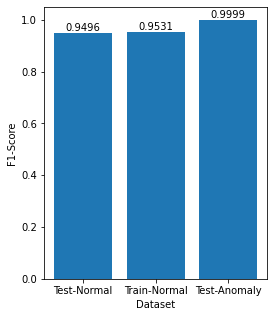

In [8]:
# import packages
import matplotlib.pyplot as plt

# plot scores
fig,ax = plt.subplots(figsize=[4,5])
ax.set(xlabel='Dataset', ylabel='F1-Score')
ax.bar(plot_df.index, plot_df['F1-Score'])
for idx,cat in enumerate(plot_df.index):
    score = plot_df.loc[cat,'F1-Score']
    ax.text(idx, score, '{:.4f}'.format(score), ha='center', va='bottom')


In [9]:
# clean up
service.delete()
remove_models()


Container has been successfully cleaned up.
